In [2]:
import os
import json 
import time
import torch
import random
import datetime
import eda_utils
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from torch.nn.functional import softmax
import torch.nn.functional as F
import torch.nn as nn 
from tqdm.auto import tqdm
from os.path import join
from IPython.display import Image
import dataframe_image as dfi
torch.manual_seed(42)
random.seed(42)

# Load files

In [3]:
dt = datetime.datetime.fromtimestamp(time.time())
logdir = os.path.join('./outputs/' ,dt.strftime('%Y-%m-%d_%H:%M:%S'))

print(f'Logging to {logdir}')
if not os.path.exists(logdir):
    os.makedirs(logdir)

path_to_imagenet = '/scratch/users/saarimrahman/imagenet-testbed/outputs'
model_names = eda_utils.model_names
imagenet_dict = eda_utils.imagenet_dict
eval_settings = ['val', 'imagenetv2-matched-frequency']

ensembled_models = [
    'top5_ensemble', 'random5_ensemble', 'top5_random5_ensemble', 
    'class_weighted_top5_ensemble', 'class_weighted_random5_ensemble', 'class_weighted_top5_random5_ensemble',
    'acc_weighted_top5_ensemble', 'acc_weighted_random5_ensemble', 'acc_weighted_top5_random5_ensemble'
]

top_models = [
    'efficientnet-l2-noisystudent', 'FixResNeXt101_32x48d_v2', 'FixResNeXt101_32x48d', 
    'instagram-resnext101_32x48d', 'efficientnet-b8-advprop-autoaug', 'BiT-M-R152x4-ILSVRC2012', 
    'efficientnet-b7-advprop-autoaug', 'instagram-resnext101_32x32d', 'BiT-M-R101x3-ILSVRC2012', 
    'efficientnet-b6-advprop-autoaug', 'efficientnet-b7-randaug', 'efficientnet-b7-autoaug',
    'efficientnet-b5-advprop-autoaug', 'resnext101_32x8d_swsl', 'instagram-resnext101_32x16d',
    'BiT-M-R50x3-ILSVRC2012', 'efficientnet-b6-autoaug', 'FixPNASNet',
    'efficientnet-b5-autoaug', 'efficientnet-b5-randaug', 'resnext101_32x4d_swsl'
]

top5_models = top_models[:5]
print('top5_models', top5_models)
# TODO: random 5 from the top 15-20
random5_models = ['FixPNASNet', 'dpn68', 'fbresnet152', 'pnasnet5large', 'vgg19']


Logging to ./outputs/2021-07-12_18:04:51
top5_models ['efficientnet-l2-noisystudent', 'FixResNeXt101_32x48d_v2', 'FixResNeXt101_32x48d', 'instagram-resnext101_32x48d', 'efficientnet-b8-advprop-autoaug']


In [4]:
def load_logits_targets(models_to_load):
    logits = defaultdict(dict)
    targets = {}
    output_folders = os.listdir(path_to_imagenet)
    for model in tqdm(models_to_load, desc='load_logits_targets', leave=False):
        for eval_setting in ['val', 'imagenetv2-matched-frequency']:
            output_folder = model + '-' + eval_setting
            if output_folder in output_folders:
                model_targets = os.path.join(path_to_imagenet, output_folder, 'targets.pt')
                model_logits = os.path.join(path_to_imagenet, output_folder, 'logits.pt')
                if os.path.exists(model_logits):
                    logits[eval_setting][model] = torch.load(model_logits)
                if eval_setting not in targets and os.path.exists(model_targets):
                    targets[eval_setting] = torch.load(model_targets)
    return logits, targets

def find_missing_logits(models, eval_setting='val'):
    print(f'Checking for missing {eval_setting} logits...')
    on_disk, missing = [], []
    output_folders = os.listdir(path_to_imagenet)
    for model in models:
        output_folder = model + '-' + eval_setting
        if output_folder in output_folders:
            model_logits = os.path.join(path_to_imagenet, output_folder, 'logits.pt')
            if os.path.exists(model_logits):
                on_disk.append(model)
            else:
                missing.append(model)
        else:
            missing.append(model)
    print(len(missing), 'models missing:', missing)
    return on_disk, missing


find_missing_logits(top5_models + random5_models, 'val')
find_missing_logits(top5_models + random5_models, 'imagenetv2-matched-frequency')

find_missing_logits(top_models[:5], 'val')
find_missing_logits(top_models[:5], 'imagenetv2-matched-frequency')

logits, targets = load_logits_targets(top5_models + random5_models)


Checking for missing val logits...
0 models missing: []
Checking for missing imagenetv2-matched-frequency logits...
0 models missing: []
Checking for missing val logits...
0 models missing: []
Checking for missing imagenetv2-matched-frequency logits...
0 models missing: []


load_logits_targets:   0%|          | 0/10 [00:00<?, ?it/s]

# Helper Functions

In [5]:
def accuracy_topk(logits, targets, topk=1):
    batch_size = targets.size(0)

    _, pred = logits.topk(topk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))

    correct_k = correct[:topk].view(-1).float().sum(0, keepdim=True)
    return correct_k.mul_(100.0 / batch_size).item()

def find_correct(logits, targets, topk=1):
    """Returns a boolean tensor showing correct predictions"""
    batch_size = targets.size(0)

    _, pred = logits.topk(topk, 1, True, True)
    pred = pred.t()
    return pred.eq(targets.view(1, -1).expand_as(pred))

def get_pred(logits, topk=1):
    _, pred = logits.topk(topk, 1, True, True)
    return pred.t()
    
def num_pairwise_errors(x_correct, y_correct):
    """Finds the number of shared elements incorrectly classified for x and y"""
    
    assert x_correct.size() == y_correct.size(), 'x and y are not the same size'
    x_error_idx = (x_correct == False).nonzero(as_tuple=True)[1]
    y_error_idx = (y_correct == False).nonzero(as_tuple=True)[1]
    return len(np.intersect1d(x_error_idx, y_error_idx))

def pairwise_corrcoef(x_logits, y_logits):
    """Applies softmax to each row of 50000 entries, flattens, then calculates correlation
    Note: Logits are originally of shape torch.Size([50000, 1000])
    """
    sigmoid_x = torch.nn.functional.softmax(x_logits, dim=1).flatten().numpy()
    sigmoid_y = torch.nn.functional.softmax(y_logits, dim=1).flatten().numpy()
    return np.corrcoef(sigmoid_x, sigmoid_y)[0][1]

def partition(data, eval_setting='val'):
    return train_test_split(data, test_size=0.5, stratify=targets[eval_setting], random_state=42)
    
def view_image(index, eval_setting='val'):
    datasets_path = '/scratch/users/saarimrahman/imagenet-testbed/s3_cache/datasets'
    eval_data_path = join(datasets_path, eval_setting)
    num_img_per_class = targets[eval_setting].size(0) // 1000
    folder_idx = index // num_img_per_class 
    img_idx = index % num_img_per_class
    folder = sorted(os.listdir(eval_data_path))[folder_idx]
    folder_path = join(eval_data_path, folder)
    file_name = sorted(os.listdir(folder_path))[img_idx]
    img_path = join(folder_path, file_name)
    print('true class:', imagenet_dict[index // num_img_per_class])
    display(Image(filename=img_path))
    
def sort_dict(dic):
    return dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))

# Ensemble

In [6]:
def get_ensemble_logits(softmax_pred):
    """Construct ensemble logits from a tensor containing all ensemble model's softmax predictions."""
    ensemble_logits = []
    for i in range(softmax_pred.size(1)): # 50000 examples
        logit = torch.mean(softmax_pred[:, i, :], 0)
        ensemble_logits.append(logit)
    
    return torch.stack(ensemble_logits)

def ensemble_models(models, eval_setting='val'):
    softmax_pred, pred = [], []
    
    for model in models:
        softmax_pred.append(softmax(logits[eval_setting][model], dim=1))
    softmax_pred = torch.stack(softmax_pred)
    
    return get_ensemble_logits(softmax_pred)

def majority_vote_models(models):
    pred = get_pred(logits['val'][models[0]])
    for model in models[1:]:
        pred = torch.cat((pred, get_pred(logits['val'][model])), 0)
    return torch.mode(pred, 0, keepdim=True)[0]

for eval_setting in ['val', 'imagenetv2-matched-frequency']:
    logits[eval_setting]['top3_ensemble'] = ensemble_models(top5_models[:3], eval_setting)
    logits[eval_setting]['top5_ensemble'] = ensemble_models(top5_models, eval_setting)
    logits[eval_setting]['random5_ensemble'] = ensemble_models(random5_models, eval_setting)
    logits[eval_setting]['top5_random5_ensemble'] = ensemble_models(top5_models + random5_models, eval_setting)

In [7]:
def class_weighted_ensemble(models, eval_setting='val'):
    """Weights each model's softmax predictions based on its relative accuracy in the class.
    Uses half of the class images to calculate in class accuracy. 
    """
    w = [] 
    for model in models:
        class_acc = []
        pred = get_pred(logits[eval_setting][model])
        miss = pred.eq(targets[eval_setting].view(1, -1).expand_as(pred)).float().flatten()
        total_images = targets[eval_setting].size(0)
        step_size = total_images // 1000
        i = 0
        while i < total_images:
            class_acc.append(miss[i:i+(step_size // 2)].sum().item() / (step_size // 2)) # calculate relative in class accuracy
            i += step_size
        w.append(torch.tensor(class_acc))
        
    w = torch.stack(w)
    
    weighted_softmax_pred = []
    for i, model in enumerate(models):
        probs = softmax(logits[eval_setting][model], dim=1)
        weighted_pred = torch.mul(probs, w[i])
        weighted_softmax_pred.append(weighted_pred) 
    
    weighted_softmax_pred = torch.stack(weighted_softmax_pred)
    return get_ensemble_logits(weighted_softmax_pred)

for eval_setting in ['val', 'imagenetv2-matched-frequency']:
    logits[eval_setting]['class_weighted_top5_ensemble'] = class_weighted_ensemble(top5_models, eval_setting)
    logits[eval_setting]['class_weighted_random5_ensemble'] = class_weighted_ensemble(random5_models, eval_setting)
    logits[eval_setting]['class_weighted_top5_random5_ensemble'] = class_weighted_ensemble(top5_models + random5_models, eval_setting)

In [8]:
def acc_weighted_ensemble(models, eval_setting='val'):
    """Weights each model's softmax predictions based on its overall accuracy on the dataset.
    Uses half of the dataset to calculate overall accuracy.
    """
    eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)

    weighted_softmax_pred = []
    for model in models:
        train_logit, _ = partition(logits[eval_setting][model], eval_setting)
        acc = accuracy_topk(train_logit, eval_targets_train)
        probs = softmax(logits[eval_setting][model], dim=1)
        weighted_pred = torch.mul(probs, acc)
        weighted_softmax_pred.append(weighted_pred) 
        
    weighted_softmax_pred = torch.stack(weighted_softmax_pred)
    return get_ensemble_logits(weighted_softmax_pred)

for eval_setting in ['val', 'imagenetv2-matched-frequency']:
    logits[eval_setting]['acc_weighted_top5_ensemble'] = acc_weighted_ensemble(top5_models, eval_setting)
    logits[eval_setting]['acc_weighted_random5_ensemble'] = acc_weighted_ensemble(random5_models, eval_setting)
    logits[eval_setting]['acc_weighted_top5_random5_ensemble'] = acc_weighted_ensemble(top5_models + random5_models, eval_setting)

# Sampling Analysis

In [68]:
# here, X and Y are classes
def sd_classifier_acc(model, eval_setting, num_classes=1000, num_iters=10000):
    rng = np.random.default_rng(42)
    
    pred = get_pred(logits[eval_setting][model])
    miss = pred.eq(targets[eval_setting].view(1, -1).expand_as(pred)).float().flatten()
    total_images = targets[eval_setting].size(0)
    step_size = total_images // 1000
    
    # we treat the accuracy over classes as a random vector Z of dimension num_classes,
    # Note Z_i takes value in [0, 1]
    # And we want to estimate Covariance of Z = E[ZZ^t] -E[Z] (E[Z])^t
    cov_acc = np.zeros((num_classes, num_classes)) # covariance estimate
    sec_mom_acc  = np.zeros((num_classes, num_classes)) # second moment E[ZZ^t]: estimated as 1/iters * sum Z Z^t (outer product)
    mean_acc = np.zeros(num_classes) # mean E[Z]; estimated as 1/iters sum Z
    # only need to loop over iterations
    avg_acc = np.zeros(num_iters)
    for ii in range(num_iters):
        # vector to capture realization of accuracy across classes for each iteration
        temp_acc = np.zeros(num_classes) 
        for x in range(num_classes):
            x_imgs = rng.choice(miss[x*step_size: (x+1)*step_size], size=10, replace=False)
            temp_acc[x] = x_imgs.sum().item() / 10
        # update the sums
        mean_acc += temp_acc
        sec_mom_acc += np.outer(temp_acc, temp_acc)
        avg_acc[ii] = np.mean(temp_acc)
        
    # normalize the sums
    sec_mom_acc /= num_iters
    mean_acc /= num_iters
    # compute the cov estimate
    cov_acc = sec_mom_acc - np.outer(mean_acc,  mean_acc)
    
    cov_acc_df = pd.DataFrame(cov_acc)
    # standard error is sqrt(Sum of all entries in the cov matrix/ num entries in the cov matrix)
    std_err = np.sqrt(np.sum(cov_acc)) / num_classes 
    inflated_std_err = np.sqrt(np.sum(np.abs(cov_acc))) / num_classes
    sum_std_err = np.sum(np.sqrt([cov_acc_df.values[i, i] for i in range(len(cov_acc_df))])) / num_classes
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(f'{model}, {eval_setting}, {num_classes} classes, {num_iters} iters \n' \
        + f'std err: {std_err:.5f}, inflated std err: {inflated_std_err:.5f}, sum std err: {sum_std_err:.3f}')
    
    # cov heatmap
    sns.heatmap(cov_acc_df.values, ax=axs[0, 0], cmap='viridis')
    axs[0, 0].set_title(f'Estimated Covariance Matrix, {num_iters} iters')
    # cov diagon entries
    axs[0, 1].plot([cov_acc_df.values[i, i] for i in range(num_classes)])
    axs[0, 1].set_title(f'Diagonal Entries of Est. Covariance Matrix')
    # histogram of avg acc
    model_class_acc = np.loadtxt(f'./outputs/2021-05-19_14:05:24/{model}')
    axs[1, 0].hist(avg_acc)
    axs[1, 0].axvline(np.mean(model_class_acc))
    axs[1, 0].set_title(f'Histogram of Averge Accuracy, {num_iters} iters')
    # parabola of true acc vs std err
    axs[1, 1].scatter([np.sqrt(cov_acc_df.values[i, i]) for i in range(len(cov_acc_df))], model_class_acc)
    axs[1, 1].set_ylabel('classwise true accuracy')
    axs[1, 1].set_xlabel('classwise std err')
    axs[1, 1].set_title(model)
    
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig((join(logdir, f'{model}_{eval_setting}_cov-acc_{num_iters}_iters.png')))
    plt.show();
    
    np.savetxt((join(logdir, f'{model}_{eval_setting}_cov-acc_{num_classes}_classes_{num_iters}_iters.csv')), cov_acc_df, delimiter=",")
    np.savetxt((join(logdir, f'{model}_{eval_setting}_avg-acc_{num_classes}_classes_{num_iters}_iters.csv')), avg_acc)
        
    if num_classes < 100:
        cov_acc_df_styled = cov_acc_df.style.background_gradient()
        dfi.export(cov_acc_df_styled, join(logdir, f'{model}_{eval_setting}_cov-acc-df_{num_classes}_classes_{num_iters}_iters.png'), max_cols=-1, max_rows=-1)

    return std_err

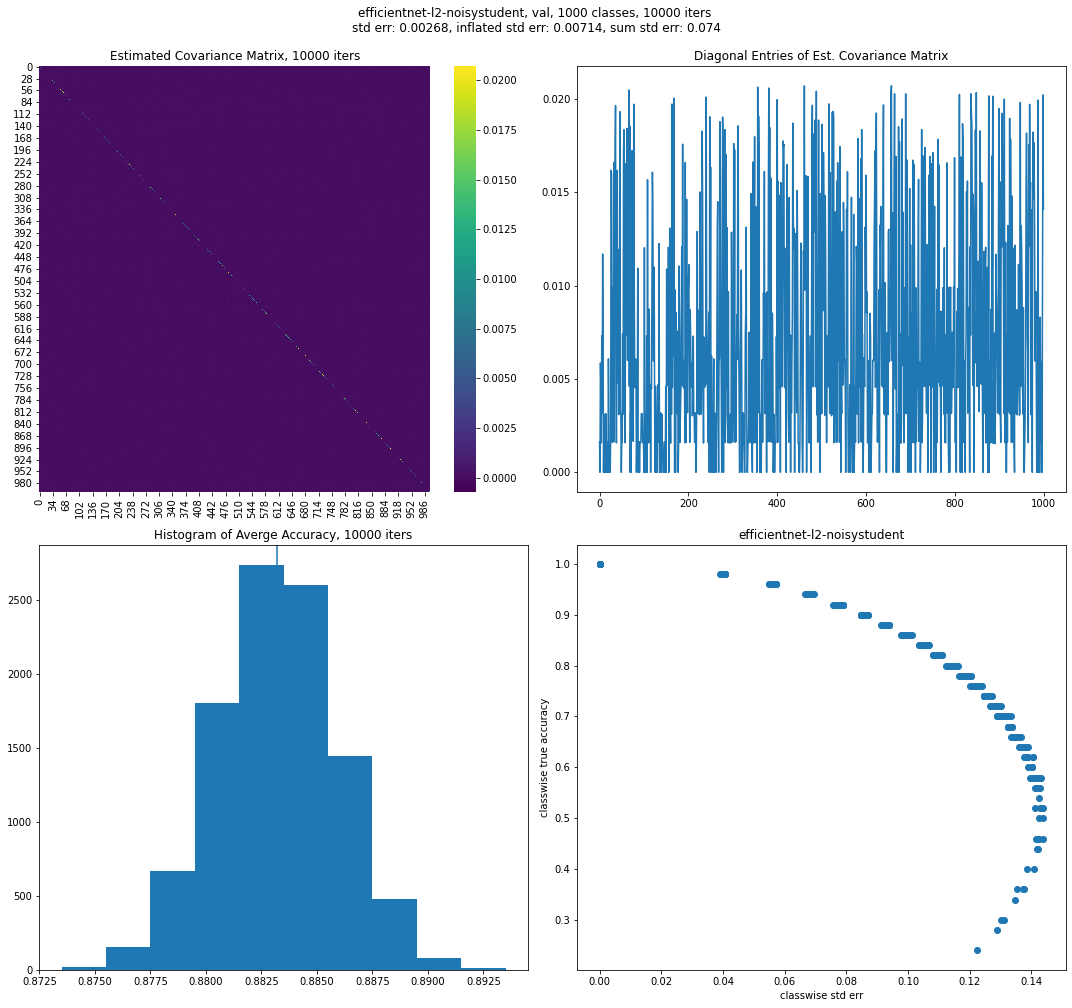

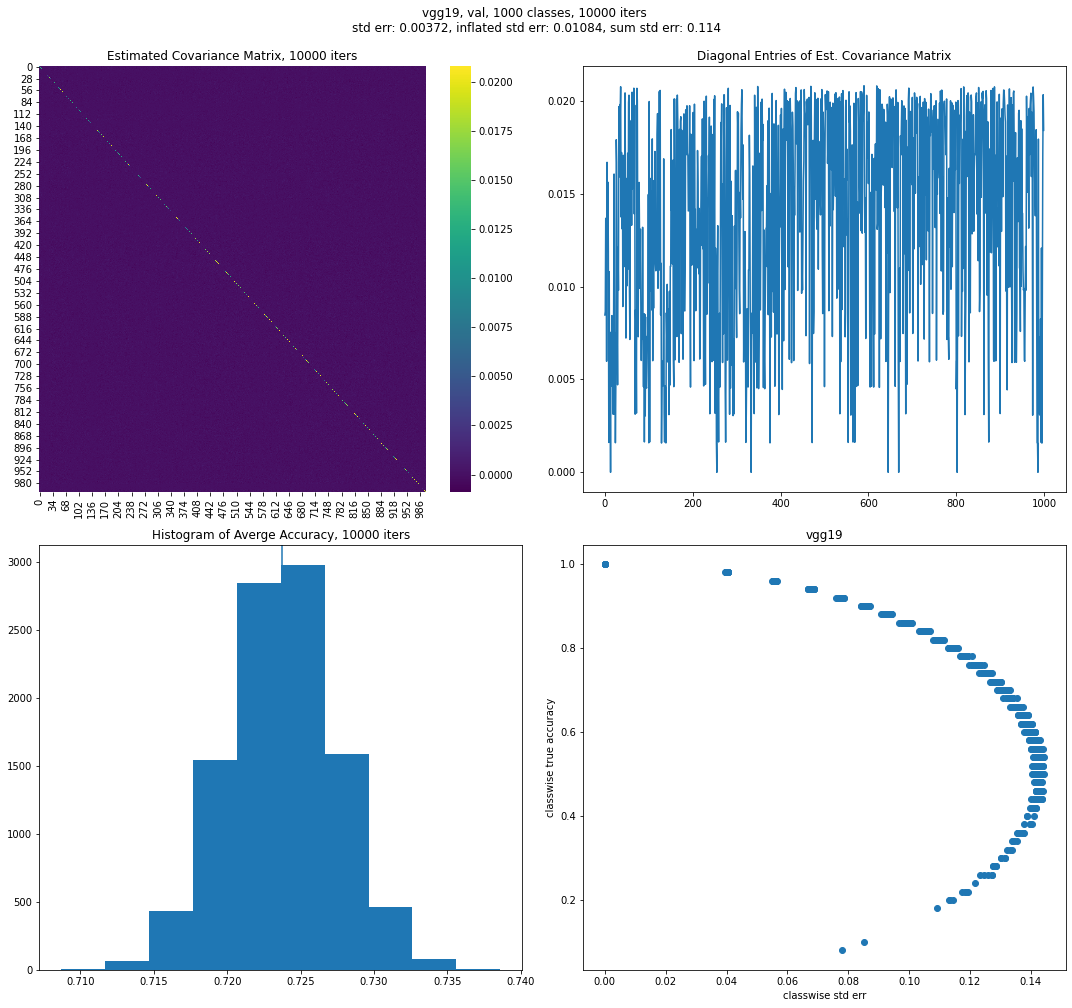

In [69]:
for model in ['efficientnet-l2-noisystudent', 'vgg19']:
    sd_classifier_acc(model, 'val', num_classes=1000, num_iters=10000)

# Accuracy & Loss of Most Confident Predictions

In [30]:
def plot_most_confident_acc(models):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    y_ax_min = float('inf')

    for model in models:
        for ax_i, eval_setting in enumerate(eval_settings):
            for ax_j, topk in enumerate([1, 3]):    
                eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)
                x = logits[eval_setting][model]
                if 'ensemble' not in model: # ensembled logits have already been through softmax
                    x = softmax(x, dim=1)
                x[x != x] = 0 # set nan values to zero.
                x = x / torch.sum(x, 1)[:, None] # normalize each image to total probability of 1

                prob, pred = x.topk(topk, 1, True, True)
                pred = pred.t()

                train_pred = []
                for i in range(pred.size(0)):
                    train_pred.append(partition(pred[i], eval_setting)[0]) # training pred
                pred = torch.stack(train_pred)
                prob = prob.sum(1) # sum normalized topk probabilities
                correct = pred.eq(eval_targets_train.view(1, -1).expand_as(pred))

                corr = []
                for i in range(correct.size(1)):
                    if correct[:,i].sum() > 0: # one of topk classified correctly
                        corr.append(True)
                    else:
                        corr.append(False)

                y_true = torch.tensor(corr).float()
                y_prob = prob.flatten()
                y_prob, _ = partition(y_prob, eval_setting)

                acc = []
                quantiles = np.arange(0.8, 1, 0.025)
                thresholds = np.quantile(y_prob, quantiles)
                for thresh in thresholds:
                    confident_prob = y_prob > thresh
                    idx = np.where(confident_prob)[0]
                    acc.append(y_true[idx].sum() / len(idx))
                    
                y_ax_min = min(y_ax_min, min(acc))
                axs[ax_i, ax_j].plot(quantiles, acc, label=f'{model}')
                axs[ax_i, ax_j].set_xlabel('quantile')
                axs[ax_i, ax_j].set_ylabel('accuracy')
                axs[ax_i, ax_j].set_title(f'{eval_setting}, top-{topk}')
                axs[ax_i, ax_j].legend(loc="best")

    for i in range(len(eval_settings)):
        for j in range(2):
            axs[i, j].set_ylim([y_ax_min - 0.01, 1.01])
            
    fig.suptitle(f'Accuracy of Most Confident Points', fontweight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(join(logdir, f'confident_points_acc'))
    plt.show();

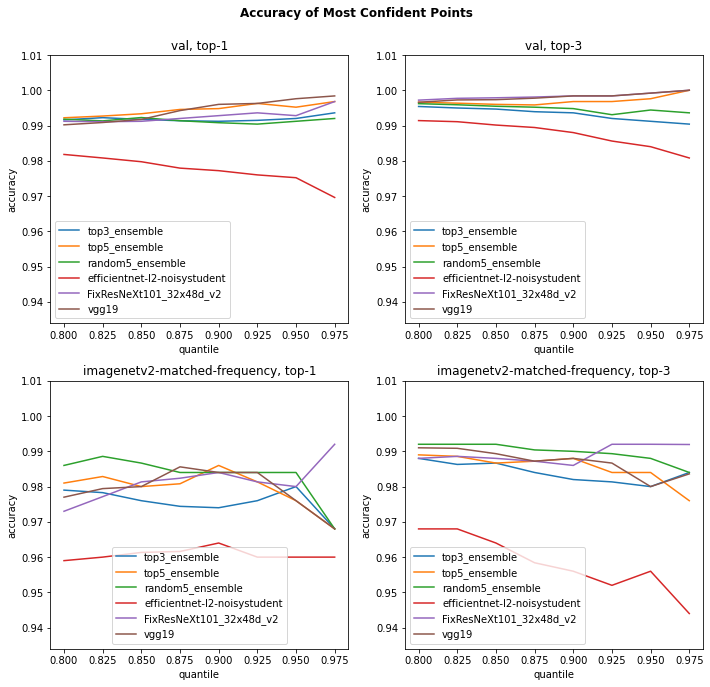

In [31]:
plot_most_confident_acc(['top3_ensemble', 'top5_ensemble', 'random5_ensemble', 'efficientnet-l2-noisystudent', 'FixResNeXt101_32x48d_v2', 'vgg19'])

In [26]:
def cross_entropy_loss(Y, Y_hat):
    Y = Y.cpu().detach().numpy()
    Y_hat = Y_hat.cpu().detach().numpy()
    
    Y_hat += 1e-15
    m = len(Y)
    return -1/m * np.sum(Y * np.log(Y_hat))

def plot_most_confident_loss(models):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    y_ax_min, y_ax_max = float('inf'), float('-inf')
    
    for model in models:
        for ax_i, eval_setting in enumerate(eval_settings):
            for ax_j, topk in enumerate([1, 3]):    
                eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)
                x = logits[eval_setting][model]
                if 'ensemble' not in model: # ensembled logits have already been through softmax
                    x = softmax(x, dim=1)
                x[x != x] = 0 # set nan values to zero.
                x = x / torch.sum(x, 1)[:, None] # normalize each image to total probability of 1

                prob, _ = x.topk(topk, 1, True, True)
                prob = prob.sum(1) # sum normalized topk probabilities

                y_prob = prob.flatten()
                y_prob, _ = partition(y_prob, eval_setting)

                Y = F.one_hot(targets[eval_setting], num_classes=1000)
                Y, _ = partition(Y, eval_setting) # training Y

                Y_hat, _ = partition(logits[eval_setting][model], eval_setting) # training Y_hat
                if 'ensemble' not in model: # ensembled logits have already been through softmax
                    Y_hat = softmax(Y_hat, dim=1)

                loss = []
                quantiles = np.arange(0.8, 1, 0.025)
                thresholds = np.quantile(y_prob, quantiles)
                for thresh in thresholds:
                    confident_prob = y_prob > thresh
                    idx = np.where(confident_prob)[0]
                    loss.append(cross_entropy_loss(Y[idx], Y_hat[idx]))

                y_ax_min = min(y_ax_min, min(loss))
                y_ax_max = max(y_ax_max, max(loss))

                axs[ax_i, ax_j].plot(quantiles, loss, label=f'{model}')
                axs[ax_i, ax_j].set_xlabel('quantiles')
                axs[ax_i, ax_j].set_ylabel('cross entropy loss')
                axs[ax_i, ax_j].set_title(f'{eval_setting}, top-{topk}')
                axs[ax_i, ax_j].legend(loc="best")
    for i in range(len(eval_settings)):
        for j in range(2):
            axs[i, j].set_ylim([y_ax_min - 0.025, y_ax_max + 0.025])
    
  
    fig.suptitle(f'Cross Entropy Loss of Most Confident Points', fontweight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(join(logdir, f'confident_points_loss'))
    plt.show();

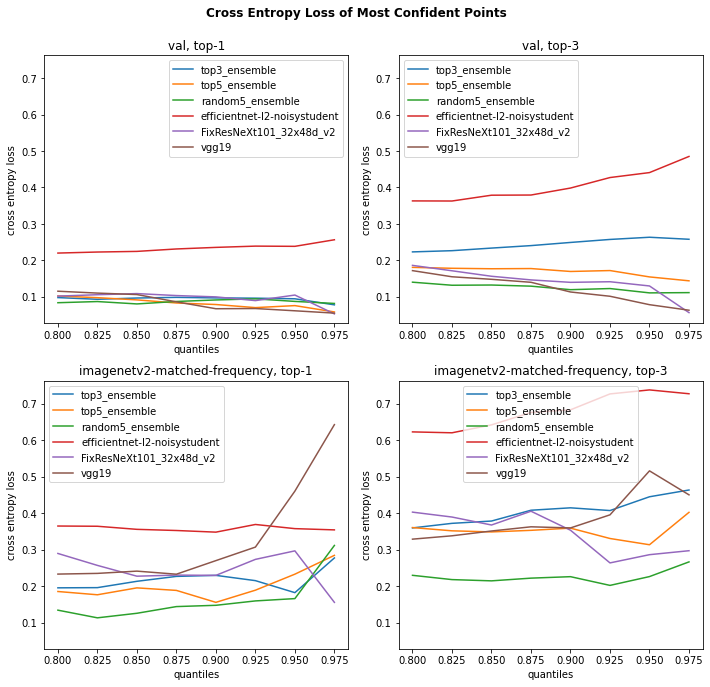

In [27]:
plot_most_confident_loss(['top3_ensemble', 'top5_ensemble', 'random5_ensemble', 'efficientnet-l2-noisystudent', 'FixResNeXt101_32x48d_v2', 'vgg19'])

# ECE vs test err plot  [E.g., Fig 1 https://arxiv.org/pdf/2106.07998.pdf ]


In [69]:
# https://arxiv.org/pdf/1706.04599.pdf eqn

In [28]:
def plot_ece_test_err(models, num_bins=10):
    """ Plots expected calibration error (ECE)  
    y_pred is the max softmax score for a given image
    y_true is if the image was correctly classified or not
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    y_ax_min, y_ax_max = float('inf'), float('-inf')
    marker = itertools.cycle(('s', 'p', 'h', 'o', '*', "X")) 
    
    for model in models:
        for ax_i, eval_setting in enumerate(eval_settings):
            for ax_j, topk in enumerate([1, 3]):  

                eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)
                x = logits[eval_setting][model]
                if 'ensemble' not in model: # ensembled logits have already been through softmax
                    x = softmax(x, dim=1)
                x[x != x] = 0 # set nan values to zero.
                x = x / torch.sum(x, 1)[:, None] # normalize each image to total probability of 1

                prob, pred = x.topk(topk, 1, True, True)
                pred = pred.t()

                train_pred = []
                for i in range(pred.size(0)):
                    train_pred.append(partition(pred[i], eval_setting)[0]) # training pred
                pred = torch.stack(train_pred)
                prob = prob.sum(1) # sum normalized topk probabilities
                correct = pred.eq(eval_targets_train.view(1, -1).expand_as(pred))

                corr = []
                for i in range(correct.size(1)):
                    if correct[:,i].sum() > 0: # one of topk classified correctly
                        corr.append(True)
                    else:
                        corr.append(False)

                y_true = torch.tensor(corr).float().flatten()
                y_prob = prob.flatten()
                y_prob, _ = partition(y_prob, eval_setting)
                
                n = len(y_true) # number of samples

                bin_size = n // num_bins
                
                bins = np.arange(0, 1, 1 / num_bins)
                bins = np.append(bins, 1)
                
                bin_idxs = []
                
                for i in range(num_bins):
                    idx_lower = np.where(y_prob > bins[i])[0]
                    idx_upper = np.where(y_prob <= bins[i+1])[0]
                    bin_idxs.append(np.intersect1d(idx_lower, idx_upper))
                                
                ece = 0                    
                for idx in bin_idxs:
                    if len(idx) == 0:
                        continue
                    acc_Bm = y_true[idx].sum().item() / len(idx)
                    conf_Bm = y_prob[idx].sum().item() / len(idx)
                    ece += len(idx) / n * abs(acc_Bm - conf_Bm)
                    
                    
                y_ax_min = min(y_ax_min, ece)
                y_ax_max = max(y_ax_max, ece)
                
                axs[ax_i, ax_j].scatter(1 - y_true.sum().item() / n, ece, label=model, marker=next(marker), linewidth=4)
                axs[ax_i, ax_j].set_xlabel('ImageNet error')
                axs[ax_i, ax_j].set_ylabel('ECE')
                axs[ax_i, ax_j].set_title(f'{eval_setting}, top-{topk}')
                axs[ax_i, ax_j].legend(loc="best")

                
    for i in range(len(eval_settings)):
        for j in range(2):
            axs[i, j].set_ylim([y_ax_min - 0.01, y_ax_max + 0.01])   
            
    fig.suptitle(f'ECE vs Test Error', fontweight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(join(logdir, f'ECE'))
    
    plt.show();

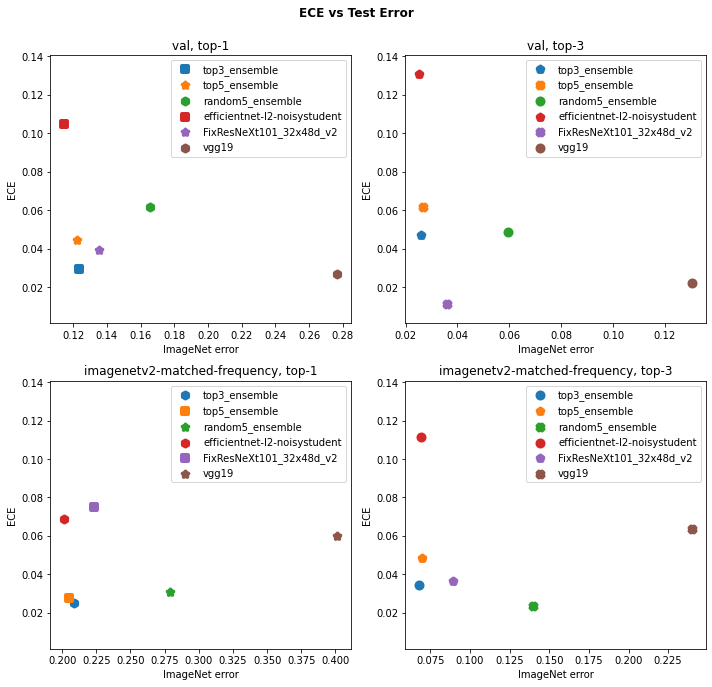

In [29]:
plot_ece_test_err(['top3_ensemble', 'top5_ensemble', 'random5_ensemble', 'efficientnet-l2-noisystudent', 'FixResNeXt101_32x48d_v2', 'vgg19'])

In [30]:
# Ensemble Variance

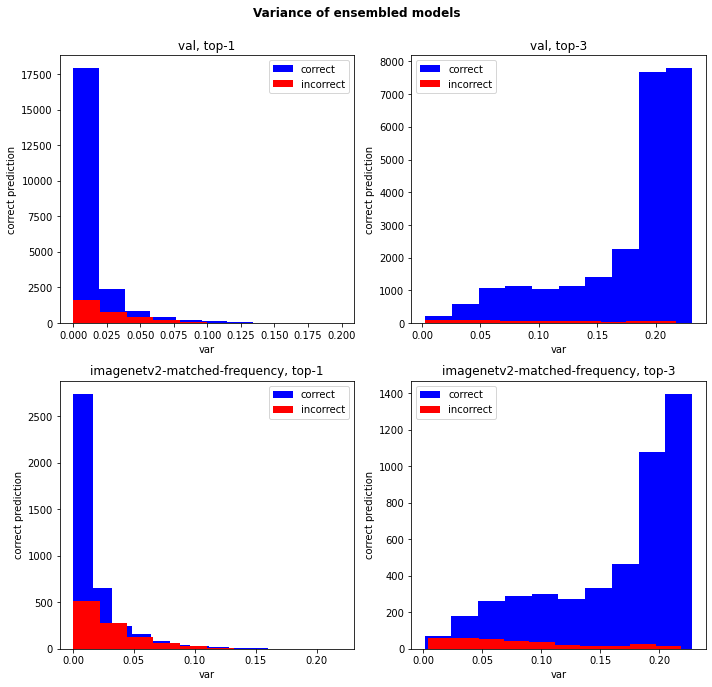

In [52]:
def plot_variance(models):
    """ Plots variance vs accuracy for """
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    y_ax_min, y_ax_max = float('inf'), float('-inf')
    marker = itertools.cycle(('s', 'p', 'h', 'o', '*', "X"))  
    
    for ax_i, eval_setting in enumerate(eval_settings):
        for ax_j, topk in enumerate([1, 3]):  
            
            # create ensembled logits
            softmax_pred = []
            for model in models:
                softmax_pred.append(softmax(logits[eval_setting][model], dim=1))
            softmax_pred = torch.stack(softmax_pred)
            
            ensemble_logits = []
            for i in range(softmax_pred.size(1)):
                logit = torch.mean(softmax_pred[:, i, :], 0)
                ensemble_logits.append(logit)
            ensemble_logits = torch.stack(ensemble_logits)

            # calculate variance of predicted prob for each image across all models in ensemble
            models_topk_probs = []
            for model in models:
                eval_targets_train, eval_targets_test = partition(targets[eval_setting], eval_setting)
                x = logits[eval_setting][model]
                if 'ensemble' not in model: # ensembled logits have already been through softmax
                    x = softmax(x, dim=1)
                x[x != x] = 0 # set nan values to zero.
                x = x / torch.sum(x, 1)[:, None] # normalize each image to total probability of 1

                prob, pred = x.topk(topk, 1, True, True)
                models_topk_probs.append(prob)
            models_topk_probs = torch.stack(models_topk_probs)
            models_topk_pred_prob_var = torch.var(models_topk_probs, (0, 2))
            models_topk_pred_prob_var, _ = partition(models_topk_pred_prob_var, eval_setting) # training var
            
            ensemble_pred = get_pred(ensemble_logits, topk)
            
            train_pred = []
            for i in range(ensemble_pred.size(0)):
                train_pred.append(partition(ensemble_pred[i], eval_setting)[0]) # training pred
            pred = torch.stack(train_pred)
            prob = prob.sum(1) # sum normalized topk probabilities
            correct = pred.eq(eval_targets_train.view(1, -1).expand_as(pred))

            corr = []
            for i in range(correct.size(1)):
                if correct[:,i].sum() > 0: # one of topk classified correctly
                    corr.append(True)
                else:
                    corr.append(False)
            
            corr = np.array(corr).astype(float)
            idx_corr = np.where(corr == 1)[0]
            idx_incorr = np.where(corr == 0)[0]
            
            axs[ax_i, ax_j].hist(models_topk_pred_prob_var[idx_corr], color='blue', label='correct')
            axs[ax_i, ax_j].hist(models_topk_pred_prob_var[idx_incorr], color='red', label='incorrect')
            axs[ax_i, ax_j].set_ylabel('correct prediction')
            axs[ax_i, ax_j].set_xlabel('var')
            axs[ax_i, ax_j].set_title(f'{eval_setting}, top-{topk}')
            axs[ax_i, ax_j].legend(loc="best")
           
    fig.suptitle(f'Variance of ensembled models', fontweight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(join(logdir, f'ensemble_var'))
    plt.show();
    
#     plt.hist(models_topk_pred_prob_var)

plot_variance(top5_models)